In [2]:
import pandas as pd
import numpy as np
import nltk
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import pickle

In [3]:
# Ensure stopwords are downloaded
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load dataset
data_file = "train.csv"  # Replace with your file path
df = pd.read_csv(data_file, encoding='latin1', header=None)
df.head()

,0,1
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


In [5]:
df.columns = [ 'sentiment', 'text']
df.head()

,sentiment,text
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


In [6]:
# Replace sentiment labels for readability
df['sentiment'] = df['sentiment'].replace({0:"Negative",1:"Negative", 2:"Negative" , 3:"Positive",4:"Positive",5:"Positive"})

In [7]:
df.head()

,sentiment,text
0,Positive,dr. goldberg offers everything i look for in a...
1,Negative,"Unfortunately, the frustration of being Dr. Go..."
2,Positive,Been going to Dr. Goldberg for over 10 years. ...
3,Positive,Got a letter in the mail last week that said D...
4,Negative,I don't know what Dr. Goldberg was like before...


In [8]:
# Text preprocessing
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:4: SyntaxWarning: invalid escape sequence '\S'
C:\Users\manik\AppData\Local\Temp\ipykernel_10864\1531488465.py:4: SyntaxWarning: invalid escape sequence '\S'
  text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


In [9]:
def preprocess(text, stem=False):
    """Cleans text by removing unwanted characters, stopwords, and optionally stems it."""
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = [stemmer.stem(token) if stem else token for token in text.split() if token not in stop_words]
    return " ".join(tokens)

df['text'] = df['text'].apply(lambda x: preprocess(x, stem=True))

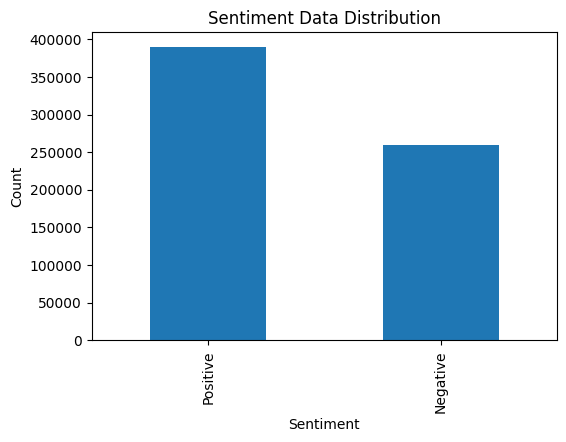

In [10]:
# Visualize Data Distribution
plt.figure(figsize=(6, 4))
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Data Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

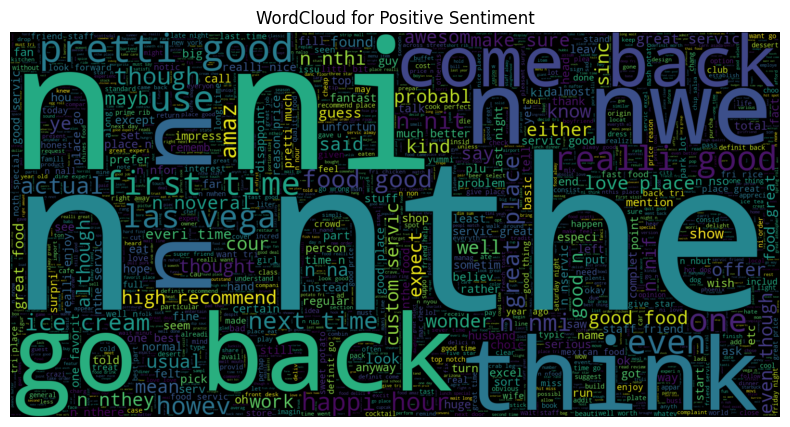

In [11]:
# WordCloud Visualization
plt.figure(figsize=(10, 5))
wc_pos = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc_pos, interpolation='bilinear')
plt.title("WordCloud for Positive Sentiment")
plt.axis("off")
plt.show()

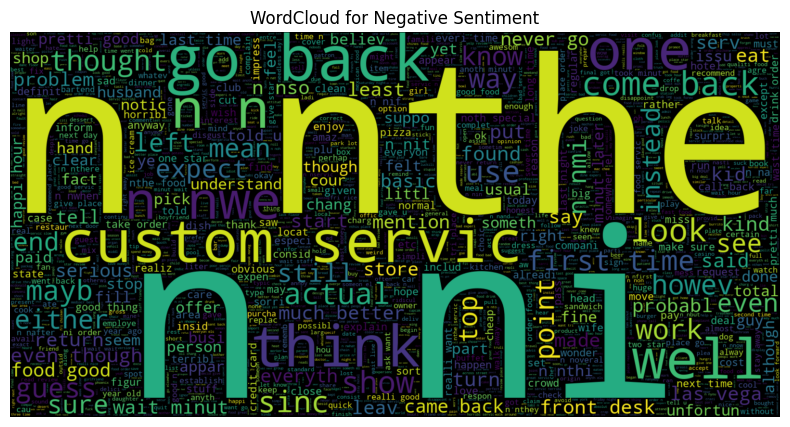

In [12]:
plt.figure(figsize=(10, 5))
wc_neg = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc_neg, interpolation='bilinear')
plt.title("WordCloud for Negative Sentiment")
plt.axis("off")
plt.show()

In [13]:
# Split data into train and test sets
X = df['text'].values
Y = df['sentiment'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)


In [14]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=20000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [15]:
# Logistic Regression Model
LR_model = LogisticRegression(max_iter=1000)
LR_model.fit(X_train_tfidf, Y_train)

LogisticRegression(max_iter=1000)

In [17]:
# Model Evaluation
def model_evaluate(model):
    """Evaluates the model on test data."""
    y_pred = model.predict(X_test_tfidf)
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

    # Classification Report
    print("Classification Report:")
    print(classification_report(Y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(Y_test, y_pred)
    categories = ['Negative', 'Positive']
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
# ROC-AUC Curve
    fpr, tpr, thresholds = roc_curve(LabelEncoder().fit_transform(Y_test), y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    print(f"ROC-AUC Score: {roc_auc:.4f}")

Evaluating Logistic Regression Model:
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.81      0.83     52000
    Positive       0.88      0.90      0.89     78000

    accuracy                           0.87    130000
   macro avg       0.86      0.86      0.86    130000
weighted avg       0.86      0.87      0.86    130000



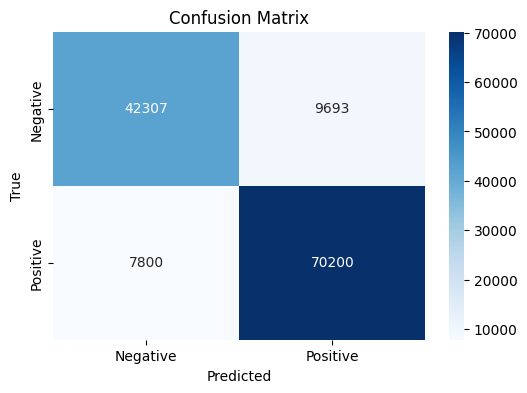

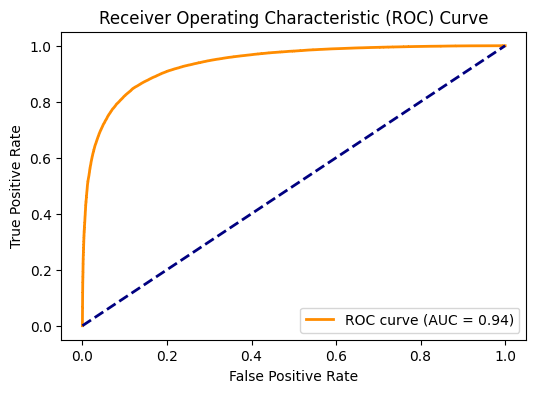

ROC-AUC Score: 0.9379


In [18]:
# Evaluate Logistic Regression
print("Evaluating Logistic Regression Model:")
model_evaluate(LR_model)

In [19]:
with open('logistic_model_hotel.sav', 'wb') as model_file:
    pickle.dump({'model': LR_model, 'vectorizer': vectorizer}, model_file)

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


In [25]:
from sklearn.naive_bayes import BernoulliNB

In [26]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)  # Encode 'Positive' -> 1, 'Negative' -> 0
Y_test_encoded = label_encoder.transform(Y_test)

In [27]:
BNB_model = BernoulliNB()
BNB_model.fit(X_train_tfidf, Y_train_encoded)

BernoulliNB()

In [28]:
y_pred = BNB_model.predict(X_test_tfidf)
y_pred_proba = BNB_model.predict_proba(X_test_tfidf)[:, 1]

In [29]:
print("Classification Report:\n", classification_report(Y_test_encoded, y_pred, target_names=["Negative", "Positive"]))


Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.64      0.69     52000
    Positive       0.78      0.86      0.82     78000

    accuracy                           0.77    130000
   macro avg       0.77      0.75      0.75    130000
weighted avg       0.77      0.77      0.77    130000



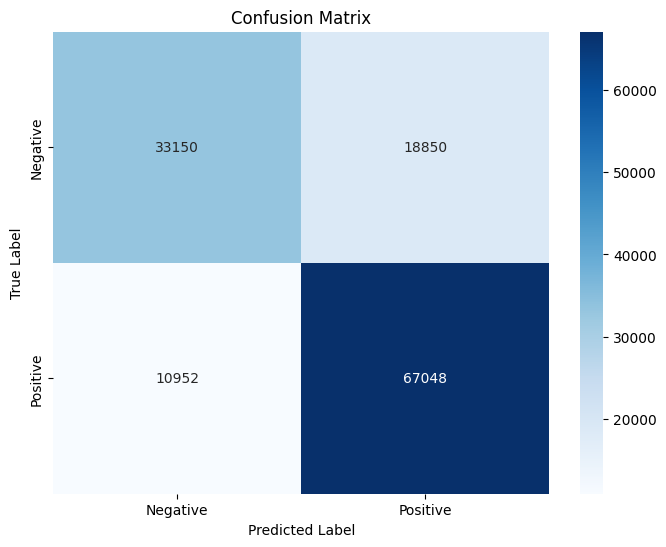

In [30]:
conf_matrix = confusion_matrix(Y_test_encoded, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

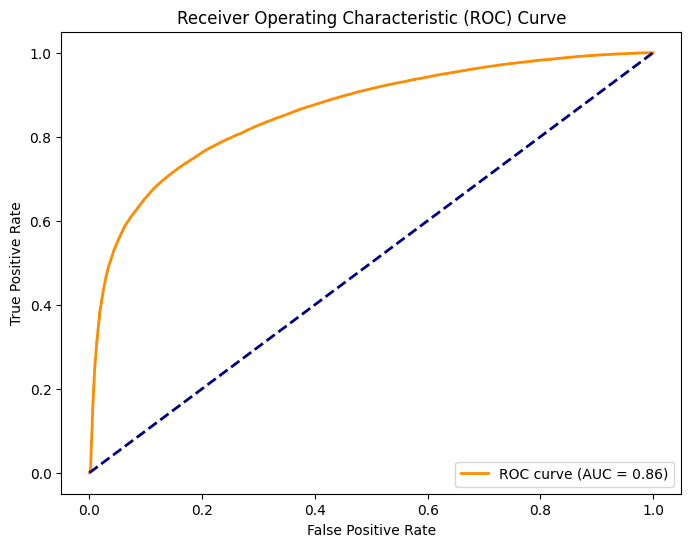

In [31]:
fpr, tpr, thresholds = roc_curve(Y_test_encoded, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC-AUC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [32]:
import pickle
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Define the preprocessing function
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
text_cleaning_re = r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"  # Fixed regex with raw string

def preprocess(text, stem=True):
    """Preprocess input text."""
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = [stemmer.stem(token) if stem else token for token in text.split() if token not in stop_words]
    return " ".join(tokens)

# Load the saved model and vectorizer
with open('logistic_model_hotel.sav', 'rb') as model_file:
    loaded_objects = pickle.load(model_file)
    loaded_model = loaded_objects['model']
    loaded_vectorizer = loaded_objects['vectorizer']

# Define sentiment mapping
sentiment_mapping = {0: 'Negative', 1: 'Positive'}

# Prediction function
def predict_sentiment(input_text):
    # Preprocess input text
    cleaned_text = preprocess(input_text)
    input_vectorized = loaded_vectorizer.transform([cleaned_text])
    
    # Make prediction
    prediction = loaded_model.predict(input_vectorized)[0]  # Predicted label (0 or 1)
    prediction_proba = loaded_model.predict_proba(input_vectorized).max()  # Highest probability
    
    # Debugging prediction output
    print(f"Prediction (numeric): {prediction}")
    
    # Map numeric label back to sentiment
    predicted_sentiment = prediction  # Fallback to "Unknown" if not found
    
    return predicted_sentiment, prediction_proba

# Example usage
input_text = "i love this product, it is quite helpful for my a day today use "
predicted_sentiment, prediction_proba = predict_sentiment(input_text)

print(f"Input: {input_text}")
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Prediction Probability: {prediction_proba:.2f}")


Prediction (numeric): Positive
Input: i love this product, it is quite helpful for my a day today use 
Predicted Sentiment: Positive
Prediction Probability: 0.96
